# Progetto 2021

**Maria Francesca Alati, matricola: 204978**

**Giulia Katia Galimberti, matricola:207019**

L'obiettivo di questo notebook è costruire un modello di classificazione che risolva il seguente task:
*   Classificazione multi-classe e multi-label di trailer di film

Il notebook è così strutturato:


1.   Get the Data
2.   Data Analysis
3.   Loading the Dataset
4.   Loading the Model
5.   Train
6.   Plot the loss
7.   Test 










Per prima cosa si importano tutte le librerie necessarie ad eseguire il codice e si accelera il runtime utilizzando la GPU.

In [1]:
SEED = 9246

import os
import json
import time
from datetime import datetime
import collections
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models

from PIL import Image

from skimage import io
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from torch.nn.modules.utils import _triple
import math

import torchsummary

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

Affinché l'esecuzione non venga interrotta è necessario copiare il seguente script nella console del browser.

In [ ]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,6000);
'''

'\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,6000);\n'

##Get the Data

Per poter accedere al dataset è necessario connettersi a Google Drive. Il dataset è stato caricato in formato zip e successivamente estratto.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/'

/content/drive/My Drive


In [ ]:
#!tar -xvzf '/content/drive/My Drive/progetto_2021_dataset_labeled.tgz' -C '/content/drive/My Drive/'

Le cartelle del progetto sono le seguenti:


*   progetto_2021_dataset
*   progetto_2021/model_checkpoint

Nella prima è contenuto il dataset estratto precedentemente mentre nella seconda verranno salvati i modelli e i checkpoint della fase di train.



In [4]:
DATASET_DIR = 'progetto_2021_dataset'
DRIVE_FOLDER = 'progetto_2021/model_checkpoint'
 
JSON_DATA = os.path.join(DATASET_DIR, 'train_test_split_dict.json')

with open(JSON_DATA) as fp:
    dataset_json = json.load(fp)
    

Il file train_test_split_dict.json è un dizionario nel quale ad ogni trailer di film è associata una lista di label che rappresentano i generi del film. I trailer sono identificati da una stringa che rappresenta il nome della cartella in cui sono contenuti i frame.

In [ ]:
print(dataset_json["train"])

{'tt4060866': ['crime', 'drama', 'action'], 'tt0014046': ['drama'], 'tt0060117': ['western'], 'tt0269266': ['horror'], 'tt1602620': ['drama'], 'tt0093771': ['crime', 'politics', 'drama', 'action'], 'tt1229360': ['documentary', 'music', 'musical'], 'tt0060436': ['drama'], 'tt4954522': ['LGBT', 'drama', 'comedy', 'horror'], 'tt0058213': ['mystery', 'drama', 'thriller', 'horror'], 'tt0079924': ['drama', 'musical'], 'tt0451850': ['fantasy', 'romantic_comedy', 'romantic'], 'tt2299954': ['drama'], 'tt0040925': ['romantic_comedy', 'musical'], 'tt0041509': ['comedy', 'musical'], 'tt1517260': ['alien', 'drama', 'fantasy', 'thriller', 'dystopic', 'teen_movie', 'space', 'action', 'futuristic', 'scifi', 'adventure', 'romantic'], 'tt0097722': ['high_school', 'drama', 'true_story', 'biopic'], 'tt3321300': ['espionage', 'thriller', 'chase', 'action', 'terrorism', 'crime'], 'tt0114216': ['drama', 'comedy'], 'tt4715356': ['thriller'], 'tt1694542': ['music', 'comedy_drama', 'romantic_comedy'], 'tt007932

## Data Analysis

Le dimensioni del dataset sono le seguenti:


*   4292 Training Set
*   1112 Test Set



In [5]:
dim_train = len(dataset_json['train'])
dim_test = len(dataset_json['test'])
print("Dimensione Train: ", dim_train)
print("Dimensione Test: ", dim_test)

Dimensione Train:  4292
Dimensione Test:  1112


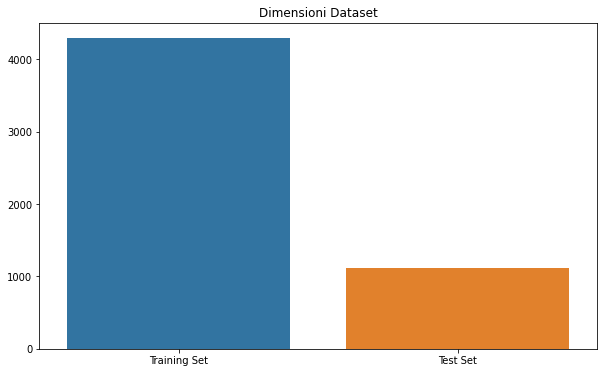

In [7]:
import seaborn as sns
plt.figure(figsize=(10,6))

# Add title
plt.title("Dimensioni Dataset")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=["Training Set", "Test Set"], y=[dim_train, dim_test])
plt.show()

In [8]:
labels = set()

for k in dataset_json.values():
    for lable_list in k.values():
        for v in lable_list:
            labels.add(v)
            
label_idx = {v: i for i, v in enumerate(sorted(labels))}

In [9]:
valori = list(dataset_json['train'].values())
valori_test = list(dataset_json['test'].values())
flat_list = [item for sublist in valori for item in sublist]
flat_list_test = [item for sublist in valori_test for item in sublist]

In [10]:
from collections import Counter
counter = Counter(flat_list)
counter_test = Counter(flat_list_test)

In [11]:
counter_dict = dict(counter)
dataframe  = pd.DataFrame.from_dict(counter, orient='index').reset_index()
dataframe_test = pd.DataFrame.from_dict(counter_test, orient='index').reset_index()
dataframe.columns = ["label", "count"]
dataframe_test.columns = ["label", "count"]

Di seguito si mostrano le 10 etichette più frequenti sia del Training Set che del Test set. E' possibile notare come i due insiemi contengano la stessa proporzione delle etichette, seppur con numerosità ovviemente differente.


In [12]:
df = dataframe.sort_values('count',ascending = False)
df.head(10)

,label,count
1,drama,2133
10,comedy,773
2,action,717
12,thriller,554
0,crime,515
4,horror,502
21,scifi,436
15,romantic,413
13,fantasy,358
14,romantic_comedy,294


In [13]:
df_test = dataframe_test.sort_values('count',ascending = False)
df_test.head(10)

,label,count
8,drama,546
7,comedy,211
24,action,191
13,thriller,139
9,crime,137
3,horror,136
39,scifi,111
30,romantic,99
17,fantasy,98
29,romantic_comedy,86


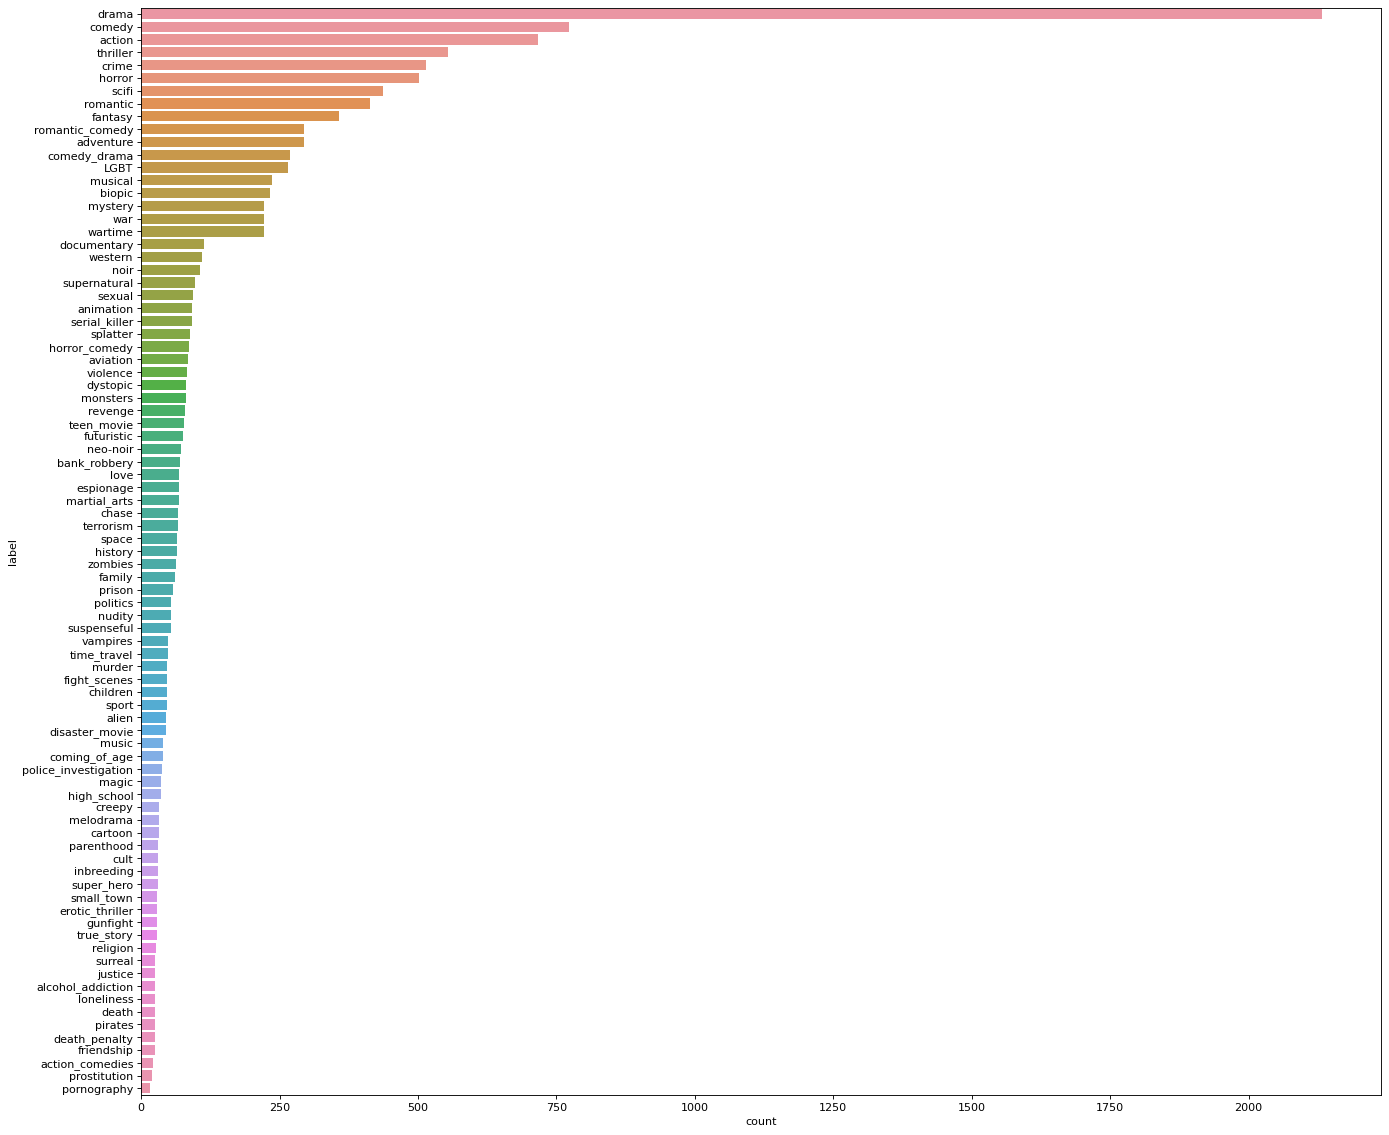

In [14]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='r')
sns.barplot(x = "count", y = "label", data = df)
plt.show()

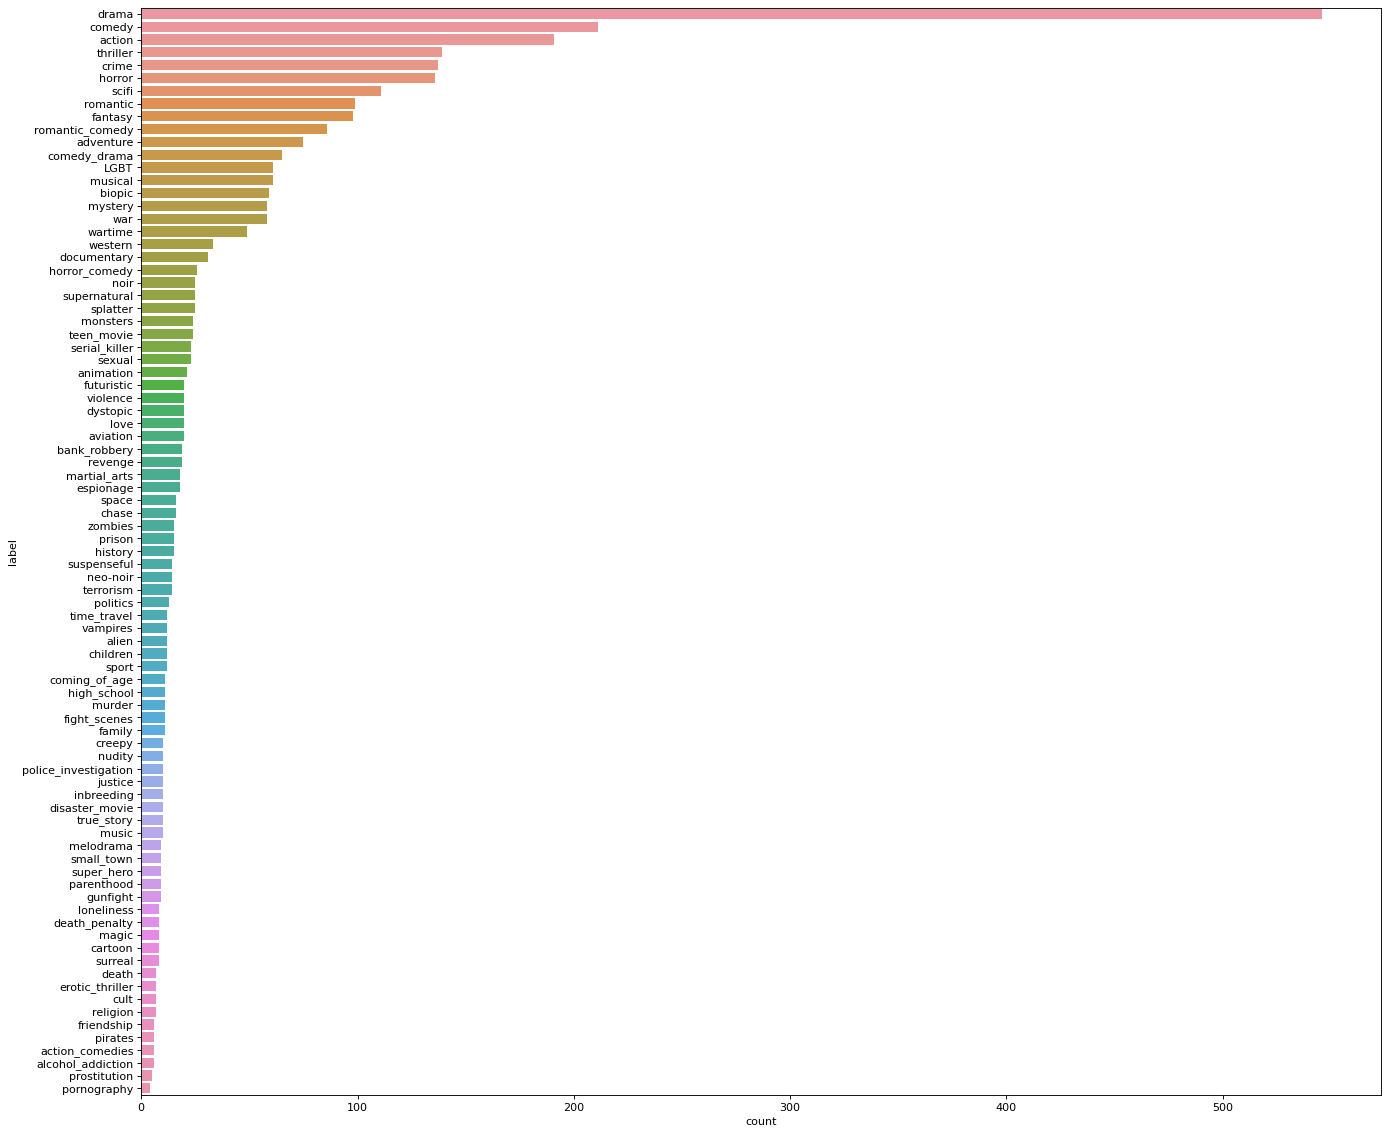

In [15]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='r')
sns.barplot(x = "count", y = "label", data = df_test)
plt.show()

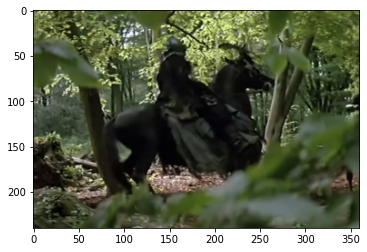

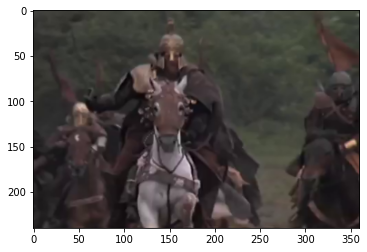

In [32]:
import cv2
from PIL import Image
trailer1 = os.path.join(DATASET_DIR, 'tt0000642')

def myResourcePath(fname):
    filename = os.path.join(trailer1, fname)
    if not os.path.exists(filename):
        raise RuntimeError(f'file not found {filename}')
    return filename


pil_image1 = Image.open(myResourcePath('frame-000003.png'))
pil_image2 = Image.open(myResourcePath('frame-000015.png'))
pil2tensor = torchvision.transforms.ToTensor()
tensor_image1 = pil2tensor(pil_image1)
tensor_image2 = pil2tensor(pil_image2)
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(tensor_image1)
plot_image(tensor_image2)




##Loading the dataset

Per la creazione del Dataset è necessario definire una classe VideoDataset che estende la classe Dataset della libreria pytorch e successivamente definire i rispettivi dataloader del training set e del test set.

In [ ]:
class VideoDataset(Dataset):

    def __init__(self, dataset_folder, labels_dict, transform=None, limit=15):
        """
        Args:
            dataset_folder (string): Path to the folder with mp4 files.
            labels_dict (dict): dict filename - list of label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_dict = labels_dict
        self.root_dir = dataset_folder
        self.limit = limit
        self.transform = transform or torchvision.transforms.ToTensor()
        
        self._files = np.array(list(self.labels_dict.keys()))

    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, idx):
        name = self._files[idx]
        
        x = torch.zeros(self.limit, 3, 100, 100)
        folder_pattern = os.path.join(self.root_dir, name, '*.png')
        images = io.imread_collection(folder_pattern)
        
        for i, image in enumerate(images):
            if i < self.limit:
                image = self.transform(Image.fromarray(image))
                x[i] = image.unsqueeze(0)

        x = x.permute(1,0,2,3)

        labels = torch.zeros(len(label_idx), dtype=torch.float32)
        for label in self.labels_dict[name]:
            labels[label_idx[label]] = 1
        
        return x, labels


transformations = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(100),
                                                  torchvision.transforms.ToTensor()])

datasetTrain = VideoDataset(DATASET_DIR, dataset_json['train'], transformations)
datasetTest = VideoDataset(DATASET_DIR, dataset_json['test'], transformations)

In [ ]:
a = datasetTrain.__getitem__(0)
print(a[0].shape)

In [ ]:
batch_size = 4
trainingDataLoader = torch.utils.data.DataLoader(datasetTrain, 
                                                 batch_size=batch_size, 
                                                 shuffle=True, num_workers = 2)
testDataLoader = torch.utils.data.DataLoader(datasetTest, 
                                             batch_size=batch_size, 
                                             shuffle=True, num_workers=2)

## Loading the model

Il modello di classificazione scelto è la rete R2Plus1D.
Le classi sono 85 e i parametri di train sono:

*   Learning Rate: 1e-4
*   Loss: BCEWithLogitsLoss
*   Optimizer: SGD
*   Scheduler: StepLR



In [ ]:
class SpatioTemporalConv(nn.Module):
    r"""Applies a factored 3D convolution over an input signal composed of several input
    planes with distinct spatial and time axes, by performing a 2D convolution over the
    spatial axes to an intermediate subspace, followed by a 1D convolution over the time
    axis to produce the final output.
    Args:
        in_channels (int): Number of channels in the input tensor
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to the sides of the input during their respective convolutions. Default: 0
        bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False, first_conv=False):
        super(SpatioTemporalConv, self).__init__()

        # if ints are entered, convert them to iterables, 1 -> [1, 1, 1]
        kernel_size = _triple(kernel_size)
        stride = _triple(stride)
        padding = _triple(padding)

        if first_conv:
            # decomposing the parameters into spatial and temporal components by
            # masking out the values with the defaults on the axis that
            # won't be convolved over. This is necessary to avoid unintentional
            # behavior such as padding being added twice
            spatial_kernel_size = kernel_size
            spatial_stride = (1, stride[1], stride[2])
            spatial_padding = padding

            temporal_kernel_size = (3, 1, 1)
            temporal_stride = (stride[0], 1, 1)
            temporal_padding = (1, 0, 0)

            # from the official code, first conv's intermed_channels = 45
            intermed_channels = 45

            # the spatial conv is effectively a 2D conv due to the
            # spatial_kernel_size, followed by batch_norm and ReLU
            self.spatial_conv = nn.Conv3d(in_channels, intermed_channels, spatial_kernel_size,
                                          stride=spatial_stride, padding=spatial_padding, bias=bias)
            self.bn1 = nn.BatchNorm3d(intermed_channels)
            # the temporal conv is effectively a 1D conv, but has batch norm
            # and ReLU added inside the model constructor, not here. This is an
            # intentional design choice, to allow this module to externally act
            # identical to a standard Conv3D, so it can be reused easily in any
            # other codebase
            self.temporal_conv = nn.Conv3d(intermed_channels, out_channels, temporal_kernel_size,
                                           stride=temporal_stride, padding=temporal_padding, bias=bias)
            self.bn2 = nn.BatchNorm3d(out_channels)
            self.relu = nn.ReLU()
        else:
            # decomposing the parameters into spatial and temporal components by
            # masking out the values with the defaults on the axis that
            # won't be convolved over. This is necessary to avoid unintentional
            # behavior such as padding being added twice
            spatial_kernel_size =  (1, kernel_size[1], kernel_size[2])
            spatial_stride =  (1, stride[1], stride[2])
            spatial_padding =  (0, padding[1], padding[2])

            temporal_kernel_size = (kernel_size[0], 1, 1)
            temporal_stride = (stride[0], 1, 1)
            temporal_padding = (padding[0], 0, 0)

            # compute the number of intermediary channels (M) using formula
            # from the paper section 3.5
            intermed_channels = int(math.floor((kernel_size[0] * kernel_size[1] * kernel_size[2] * in_channels * out_channels)/ \
                                (kernel_size[1] * kernel_size[2] * in_channels + kernel_size[0] * out_channels)))

            # the spatial conv is effectively a 2D conv due to the
            # spatial_kernel_size, followed by batch_norm and ReLU
            self.spatial_conv = nn.Conv3d(in_channels, intermed_channels, spatial_kernel_size,
                                        stride=spatial_stride, padding=spatial_padding, bias=bias)
            self.bn1 = nn.BatchNorm3d(intermed_channels)

            # the temporal conv is effectively a 1D conv, but has batch norm
            # and ReLU added inside the model constructor, not here. This is an
            # intentional design choice, to allow this module to externally act
            # identical to a standard Conv3D, so it can be reused easily in any
            # other codebase
            self.temporal_conv = nn.Conv3d(intermed_channels, out_channels, temporal_kernel_size,
                                        stride=temporal_stride, padding=temporal_padding, bias=bias)
            self.bn2 = nn.BatchNorm3d(out_channels)
            self.relu = nn.ReLU()



    def forward(self, x):
        x = self.relu(self.bn1(self.spatial_conv(x)))
        x = self.relu(self.bn2(self.temporal_conv(x)))
        return x


class SpatioTemporalResBlock(nn.Module):
    r"""Single block for the ResNet network. Uses SpatioTemporalConv in
        the standard ResNet block layout (conv->batchnorm->ReLU->conv->batchnorm->sum->ReLU)
        Args:
            in_channels (int): Number of channels in the input tensor.
            out_channels (int): Number of channels in the output produced by the block.
            kernel_size (int or tuple): Size of the convolving kernels.
            downsample (bool, optional): If ``True``, the output size is to be smaller than the input. Default: ``False``
        """

    def __init__(self, in_channels, out_channels, kernel_size, downsample=False):
        super(SpatioTemporalResBlock, self).__init__()

        # If downsample == True, the first conv of the layer has stride = 2
        # to halve the residual output size, and the input x is passed
        # through a seperate 1x1x1 conv with stride = 2 to also halve it.

        # no pooling layers are used inside ResNet
        self.downsample = downsample

        # to allow for SAME padding
        padding = kernel_size // 2

        if self.downsample:
            # downsample with stride =2 the input x
            self.downsampleconv = SpatioTemporalConv(in_channels, out_channels, 1, stride=2)
            self.downsamplebn = nn.BatchNorm3d(out_channels)

            # downsample with stride = 2when producing the residual
            self.conv1 = SpatioTemporalConv(in_channels, out_channels, kernel_size, padding=padding, stride=2)
        else:
            self.conv1 = SpatioTemporalConv(in_channels, out_channels, kernel_size, padding=padding)

        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()

        # standard conv->batchnorm->ReLU
        self.conv2 = SpatioTemporalConv(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        res = self.relu(self.bn1(self.conv1(x)))
        res = self.bn2(self.conv2(res))

        if self.downsample:
            x = self.downsamplebn(self.downsampleconv(x))

        return self.relu(x + res)


class SpatioTemporalResLayer(nn.Module):
    r"""Forms a single layer of the ResNet network, with a number of repeating
    blocks of same output size stacked on top of each other
        Args:
            in_channels (int): Number of channels in the input tensor.
            out_channels (int): Number of channels in the output produced by the layer.
            kernel_size (int or tuple): Size of the convolving kernels.
            layer_size (int): Number of blocks to be stacked to form the layer
            block_type (Module, optional): Type of block that is to be used to form the layer. Default: SpatioTemporalResBlock.
            downsample (bool, optional): If ``True``, the first block in layer will implement downsampling. Default: ``False``
        """

    def __init__(self, in_channels, out_channels, kernel_size, layer_size, block_type=SpatioTemporalResBlock,
                 downsample=False):

        super(SpatioTemporalResLayer, self).__init__()

        # implement the first block
        self.block1 = block_type(in_channels, out_channels, kernel_size, downsample)

        # prepare module list to hold all (layer_size - 1) blocks
        self.blocks = nn.ModuleList([])
        for i in range(layer_size - 1):
            # all these blocks are identical, and have downsample = False by default
            self.blocks += [block_type(out_channels, out_channels, kernel_size)]

    def forward(self, x):
        x = self.block1(x)
        for block in self.blocks:
            x = block(x)

        return x


class R2Plus1DNet(nn.Module):
    r"""Forms the overall ResNet feature extractor by initializng 5 layers, with the number of blocks in
    each layer set by layer_sizes, and by performing a global average pool at the end producing a
    512-dimensional vector for each element in the batch.
        Args:
            layer_sizes (tuple): An iterable containing the number of blocks in each layer
            block_type (Module, optional): Type of block that is to be used to form the layers. Default: SpatioTemporalResBlock.
    """

    def __init__(self, layer_sizes, block_type=SpatioTemporalResBlock):
        super(R2Plus1DNet, self).__init__()

        # first conv, with stride 1x2x2 and kernel size 1x7x7
        self.conv1 = SpatioTemporalConv(3, 64, (1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), first_conv=True)
        # output of conv2 is same size as of conv1, no downsampling needed. kernel_size 3x3x3
        self.conv2 = SpatioTemporalResLayer(64, 64, 3, layer_sizes[0], block_type=block_type)
        # each of the final three layers doubles num_channels, while performing downsampling
        # inside the first block
        self.conv3 = SpatioTemporalResLayer(64, 128, 3, layer_sizes[1], block_type=block_type, downsample=True)
        self.conv4 = SpatioTemporalResLayer(128, 256, 3, layer_sizes[2], block_type=block_type, downsample=True)
        self.conv5 = SpatioTemporalResLayer(256, 512, 3, layer_sizes[3], block_type=block_type, downsample=True)

        # global average pooling of the output
        self.pool = nn.AdaptiveAvgPool3d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.pool(x)

        return x.view(-1, 512)


class R2Plus1DClassifier(nn.Module):
    r"""Forms a complete ResNet classifier producing vectors of size num_classes, by initializng 5 layers,
    with the number of blocks in each layer set by layer_sizes, and by performing a global average pool
    at the end producing a 512-dimensional vector for each element in the batch,
    and passing them through a Linear layer.
        Args:
            num_classes(int): Number of classes in the data
            layer_sizes (tuple): An iterable containing the number of blocks in each layer
            block_type (Module, optional): Type of block that is to be used to form the layers. Default: SpatioTemporalResBlock.
        """

    def __init__(self, num_classes, layer_sizes, block_type=SpatioTemporalResBlock, pretrained=False):
        super(R2Plus1DClassifier, self).__init__()

        self.res2plus1d = R2Plus1DNet(layer_sizes, block_type)
        self.linear = nn.Linear(512, num_classes)

        self.__init_weight()

        if pretrained:
            self.__load_pretrained_weights()

    def forward(self, x):
        x = self.res2plus1d(x)
        logits = self.linear(x)

        return logits

    def __load_pretrained_weights(self):
        s_dict = self.state_dict()
        for name in s_dict:
            print(name)
            print(s_dict[name].size())

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def get_1x_lr_params(model):
    """
    This generator returns all the parameters for the conv layer of the net.
    """
    b = [model.res2plus1d]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k


def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the fc layer of the net.
    """
    b = [model.linear]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

Funzioni necessarie per salvare/caricare il modello e i checkpoint

In [ ]:
CHECKPOINT = os.path.join(DRIVE_FOLDER, 'model.checkpoint')
MODELFILE = os.path.join(DRIVE_FOLDER, 'model.pth')

def save_checkpoint(epoch, model, optimizer, loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT)

def load_checkpoint(model, optimizer):
    if not os.path.exists(CHECKPOINT):
        return None, None
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss

def save_model(model):
    torch.save(model.state_dict(), MODELFILE)

def load_model(model):
    if os.path.exists(MODELFILE):
        model.load_state_dict(torch.load(MODELFILE))


In [ ]:
lr = 1e-4
num_classes=85
criterion = nn.BCEWithLogitsLoss()

model = R2Plus1DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
train_params = [{'params': get_1x_lr_params(model), 'lr': lr},
                        {'params': get_10x_lr_params(model), 'lr': lr * 10}]

                        
optimizer = optim.SGD(train_params, lr=lr, momentum=0.8, weight_decay=5e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)


In [ ]:
lr = 1e-4

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(train_params, lr=lr, momentum=0.8, weight_decay=5e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

epochs = 10

In [ ]:
model.cuda()
load_model(model)

R2Plus1DClassifier(
  (res2plus1d): R2Plus1DNet(
    (conv1): SpatioTemporalConv(
      (spatial_conv): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (bn1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (temporal_conv): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2): SpatioTemporalResLayer(
      (block1): SpatioTemporalResBlock(
        (conv1): SpatioTemporalConv(
          (spatial_conv): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (bn1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (temporal_conv): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (bn2): BatchNorm3d(64, eps=1e-05, mo

##Train

Per la fase di Train sono state eseguite 10 epoche:



In [ ]:
epochs = 10
train_losses = []
last_epoch = 0
print_every = 10

try:
    for epoch in range(last_epoch or 0, epochs):
        print('Start epoch', epoch+1)
        model.train()
        running_loss = 0
        steps = 0
        for x, y in trainingDataLoader:

            steps += 1
            x, y = x.to(device), y.to(device)

            if epoch == 0 and steps == 1:
                print(f'input shape is {x.shape}, labels are {y.shape}')

            optimizer.zero_grad()
            logit = model(x)

            loss = criterion(logit, y)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()
            
            # TRAIN unlabeled batch
            # ...
            
            if steps % print_every == 0:
                print(f"epoch {epoch+1}/{epochs} "
                      f"train loss: {running_loss/steps:.6f} ")

                save_checkpoint(epoch, model, optimizer, loss)

        save_model(model)
        train_losses.append(running_loss/steps)
        print(f"END Epoch {epoch+1}/{epochs} "
              f"Train loss: {running_loss/steps:.6f} ")
        
        if (epoch + 1) % 10 == 0:
            print('*'*50)
            test(model)
            print('*'*50)
except KeyboardInterrupt: 
    print('Exiting from training early')

save_model(model)

Start epoch 1
input shape is torch.Size([4, 3, 15, 100, 100]), labels are torch.Size([4, 85])
epoch 1/10 train loss: 0.723588 
epoch 1/10 train loss: 0.703862 
epoch 1/10 train loss: 0.686418 
epoch 1/10 train loss: 0.670859 
epoch 1/10 train loss: 0.655286 
epoch 1/10 train loss: 0.640037 
epoch 1/10 train loss: 0.626625 
epoch 1/10 train loss: 0.613272 
epoch 1/10 train loss: 0.601231 
epoch 1/10 train loss: 0.591207 
epoch 1/10 train loss: 0.580477 
epoch 1/10 train loss: 0.571424 
epoch 1/10 train loss: 0.562021 
epoch 1/10 train loss: 0.553202 
epoch 1/10 train loss: 0.545216 
epoch 1/10 train loss: 0.537349 
epoch 1/10 train loss: 0.529886 
epoch 1/10 train loss: 0.522995 
epoch 1/10 train loss: 0.515574 
epoch 1/10 train loss: 0.509192 
epoch 1/10 train loss: 0.503495 
epoch 1/10 train loss: 0.497804 
epoch 1/10 train loss: 0.492220 
epoch 1/10 train loss: 0.486689 
epoch 1/10 train loss: 0.481771 
epoch 1/10 train loss: 0.477245 
epoch 1/10 train loss: 0.472428 
epoch 1/10 trai

NameError: ignored

## Plot loss

Di seguito si mostra l'andamento della loss nelle 10 epoche eseguite. E' possibile notare come la loss si sia assestata intorno al valore 0.12, per cui non è stato necessario eseguire ulteriori epoche.



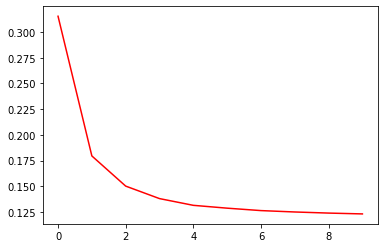

In [ ]:
plt.plot(np.array(train_losses), 'r')

## Test Suite

Infine, per la valutazione del modello ottenuto è stato utilizzato il test set e di seguito si mostra il classification report con le relative misure richieste.

In [ ]:
topk=10
predictions = []
y_true = []

model.eval()

with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs = inputs.to(device)

        logps = model(inputs)
        y_pred = torch.sigmoid(logps)

        _, idx = y_pred.topk(topk, dim=1)

        y_pred = torch.zeros_like(y_pred)
        y_pred.scatter_(1, idx, 1)
        predictions.append(y_pred.cpu())

        y_true.append(labels.cpu())


y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
report = classification_report(y_true, predictions, 
                               target_names=list(sorted(label_idx.keys())))
print(report)

                      precision    recall  f1-score   support

                LGBT       0.07      0.03      0.04        61
              action       0.17      1.00      0.29       191
     action_comedies       0.00      0.00      0.00         6
           adventure       0.08      0.51      0.13        75
   alcohol_addiction       0.00      0.00      0.00         6
               alien       0.00      0.00      0.00        12
           animation       0.00      0.00      0.00        21
            aviation       0.00      0.00      0.00        20
        bank_robbery       0.00      0.00      0.00        19
              biopic       0.00      0.00      0.00        59
             cartoon       0.00      0.00      0.00         8
               chase       0.00      0.00      0.00        16
            children       0.00      0.00      0.00        12
              comedy       0.19      1.00      0.32       211
        comedy_drama       0.09      0.52      0.15        65
       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I valori ottenuti raggiungono la Baseline 2 che richiedeva le seguenti specifiche:


1.   Micro f1: 0.25
2.   Micro precision >= 0.15
3.   Micro recall >= 0.50


In [ ]:
from sklearn import metrics
print("Valore Micro F1: %.2f" % metrics.f1_score(y_true, predictions, average='micro'))
print("Valore Micro Precision: %.2f" % metrics.precision_score(y_true, predictions, average='micro'))
print("Valore Micro Recall: %.2f" % metrics.recall_score(y_true, predictions, average='micro'))

Valore Micro F1: 0.25
Valore Micro Precision: 0.16
Valore Micro Recall: 0.56
